In [1]:
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
%config IPCompleter.greedy=True
import joblib

In [2]:
samples = joblib.load('samples.sav')
list_CpGs = joblib.load('list_CpGs.sav')
list_patterns = joblib.load('list_patterns.sav')
list_each_cpg = joblib.load('list_each_cpg.sav')
CpG_positions = joblib.load('CpG_positions.sav')
CpG_num = joblib.load('CpG_num.sav')
colors = joblib.load('colors.sav')
CpG_targets = joblib.load('CpG_targets.sav')

In [4]:
set(samples["Group ID"])

{'CD', 'CL', 'Ctrl', 'DD', 'FD', 'MN', 'MP', 'MU', 'TR'}

dict_keys(['cg22797031', 'cg27630153', 'cg19586199', 'cg15289427'])

In [7]:
for cpg in CpG_targets:
    list_CpGs[cpg].to_csv(cpg+"_region_DNAm_signal.csv", index=False, sep="\t")

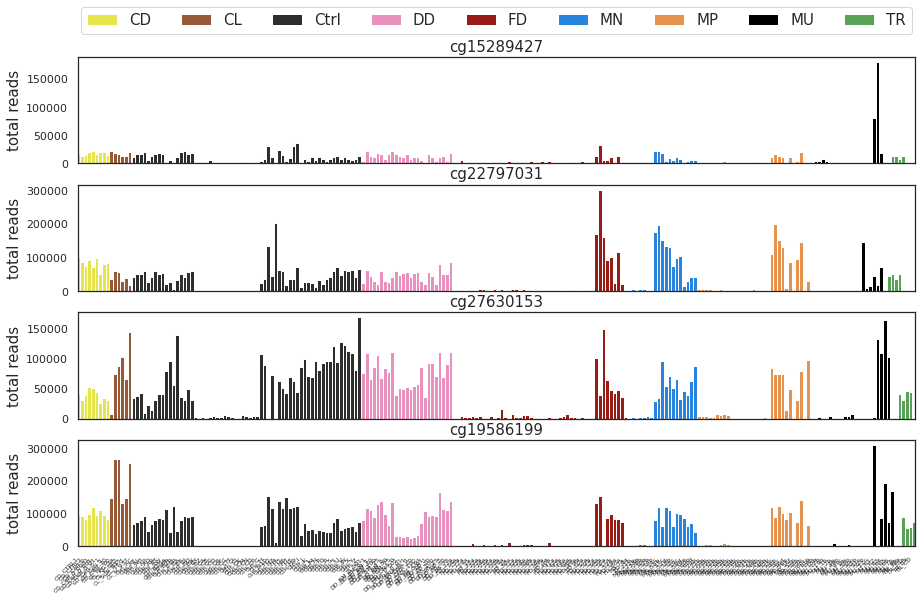

In [13]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

f, axs = plt.subplots(len(CpG_targets), 1, figsize=(15, 9), sharex=True)
sns.set(rc={"font.size":15,
            "axes.titlesize":15,
            "axes.labelsize":15,
            'legend.fontsize': 15,
            "legend.title_fontsize": 15}, style="white")
for i, target in enumerate(CpG_targets):
    t = list_patterns[target][["group", "id", "total_reads"]].drop_duplicates()
    t = t.sort_values(["group", "id"], ascending=[1, 1]).reset_index()
    
    sns.barplot(x="id", y="total_reads", hue="group", data=t, ax=axs[i], palette=colors)
    plt.xticks(rotation=45, ha="right", fontsize=6)
    change_width(axs[i], 1)
    axs[i].set_title(target)
    axs[i].set_ylabel("total reads")
    axs[i].set_xlabel("")
    if i == 0:
        axs[i].legend(bbox_to_anchor=(0.5, 1.15), ncol=9, loc=8)
    else:
        axs[i].get_legend().remove()
        
plt.savefig('FigS5_total_reads_samples.pdf')
plt.savefig('FigS5_total_reads_samples.png', dpi=600)

In [5]:
for i, target in enumerate(CpG_targets):
    t = list_patterns[target][["group", "id", "total_reads"]].drop_duplicates()
    t = t.sort_values(["group", "id"], ascending=[1, 1]).reset_index()
    print(target)
    print(t.mean())


cg15289427
index          37398.801762
total_reads     8527.118943
dtype: float64
cg22797031
index          39663.486726
total_reads    36051.504425
dtype: float64
cg27630153
index          296630.152838
total_reads     37370.816594
dtype: float64
cg19586199
index          28931.273913
total_reads    51364.039130
dtype: float64


In [14]:
for i, target in enumerate(CpG_targets):
    t = list_patterns[target][["group", "id", "total_reads"]].drop_duplicates()
    print(target)
    t = t.loc[t["total_reads"]<50,"id"]
    print(t)

cg15289427
62125    MN_59d
74369    MP_56f
76441    MP_59b
80361     MU_62
91067     MU_7b
Name: id, dtype: object
cg22797031
15747    Ctrl_CO
74246      MU_7b
Name: id, dtype: object
cg27630153
343838    FD_24a
506093    MU_11b
506094    MU_15b
531272     MU_7b
Name: id, dtype: object
cg19586199
Series([], Name: id, dtype: object)


In [4]:
def plot_pattern_heatmap(target_group, sample_id=None):
    max_perpage = 6
    
    if sample_id:
        ids = [sample_id]
        n_sam = 1
    else:
        ids = samples.loc[samples["Group ID"]==target_group,"ID"].values.tolist()
        n_sam = samples.groupby("Group ID").size()[target_group]
    
    pages = n_sam // max_perpage + 1
    
    for p in range(pages):
        if p == pages - 1:
            ind_begin = p*max_perpage
#             p_ceiling = len(ids) - 1
            ind_end = len(ids) - 1
        else:
            ind_begin = p*max_perpage
            ind_end = (p+1)*max_perpage - 1
        print([n_sam, p, pages, ind_begin, ind_end, max_perpage])
        
        f, axs = plt.subplots(max_perpage, len(CpG_targets), figsize=(15, 3*max_perpage), sharex=False)

        sns.set(rc={"font.size":25,
                    "axes.titlesize":15,
                    "axes.labelsize":10,
                    'legend.fontsize': 20,
                    "legend.title_fontsize": 20,
                    'xtick.labelsize': 10}, style="white")

        for i, target in enumerate(CpG_targets):
            print("\t".join([target_group, "page"+str(p+1), target]), end="")
            id_range = [ids[x] for x in range(ind_begin, ind_end+1)]
#             print(id_range)
            for j, sam_id in enumerate(id_range):
                print(".", end="")
#                 print([j, i])
                t = list_CpGs[target].loc[list_CpGs[target]["id"]==sam_id,].drop(["group", 
                                                                                  "id", 
                                                                                  "pattern"], axis=1)
                if t.empty:
                    continue
                t = t.replace("-", np.nan)
                t = t.apply(pd.to_numeric)
                sns.heatmap(t, ax=axs[j, i], xticklabels=False, yticklabels=False,
                            cbar=False,cmap='Blues')
                if i == 0:
                    axs[j, i].set_ylabel(sam_id + " (" + str(t.shape[0]) + ")")
                if j == 0:
                    axs[j, i].set_title(target)
            print()
        plt.tight_layout(h_pad=0.5)
        if sample_id:
            plt.savefig("raw_methyl_pattern_"+sample_id+'.png', dpi=600)
        else:
            plt.savefig("raw_methyl_pattern_"+target_group+'_'+str(p+1)+'.png', dpi=600)
        

[62, 0, 11, 0, 5, 6]
Ctrl	page1	cg15289427......
Ctrl	page1	cg22797031......
Ctrl	page1	cg27630153......
Ctrl	page1	cg19586199......
[62, 1, 11, 6, 11, 6]
Ctrl	page2	cg15289427......
Ctrl	page2	cg22797031......
Ctrl	page2	cg27630153......
Ctrl	page2	cg19586199......
[62, 2, 11, 12, 17, 6]
Ctrl	page3	cg15289427......
Ctrl	page3	cg22797031......
Ctrl	page3	cg27630153......
Ctrl	page3	cg19586199......
[62, 3, 11, 18, 23, 6]
Ctrl	page4	cg15289427......
Ctrl	page4	cg22797031......
Ctrl	page4	cg27630153......
Ctrl	page4	cg19586199......
[62, 4, 11, 24, 29, 6]
Ctrl	page5	cg15289427......
Ctrl	page5	cg22797031......
Ctrl	page5	cg27630153......
Ctrl	page5	cg19586199......
[62, 5, 11, 30, 35, 6]
Ctrl	page6	cg15289427......
Ctrl	page6	cg22797031......
Ctrl	page6	cg27630153......
Ctrl	page6	cg19586199......
[62, 6, 11, 36, 41, 6]
Ctrl	page7	cg15289427......
Ctrl	page7	cg22797031......
Ctrl	page7	cg27630153......
Ctrl	page7	cg19586199......
[62, 7, 11, 42, 47, 6]
Ctrl	page8	cg15289427......
Ctrl	pa

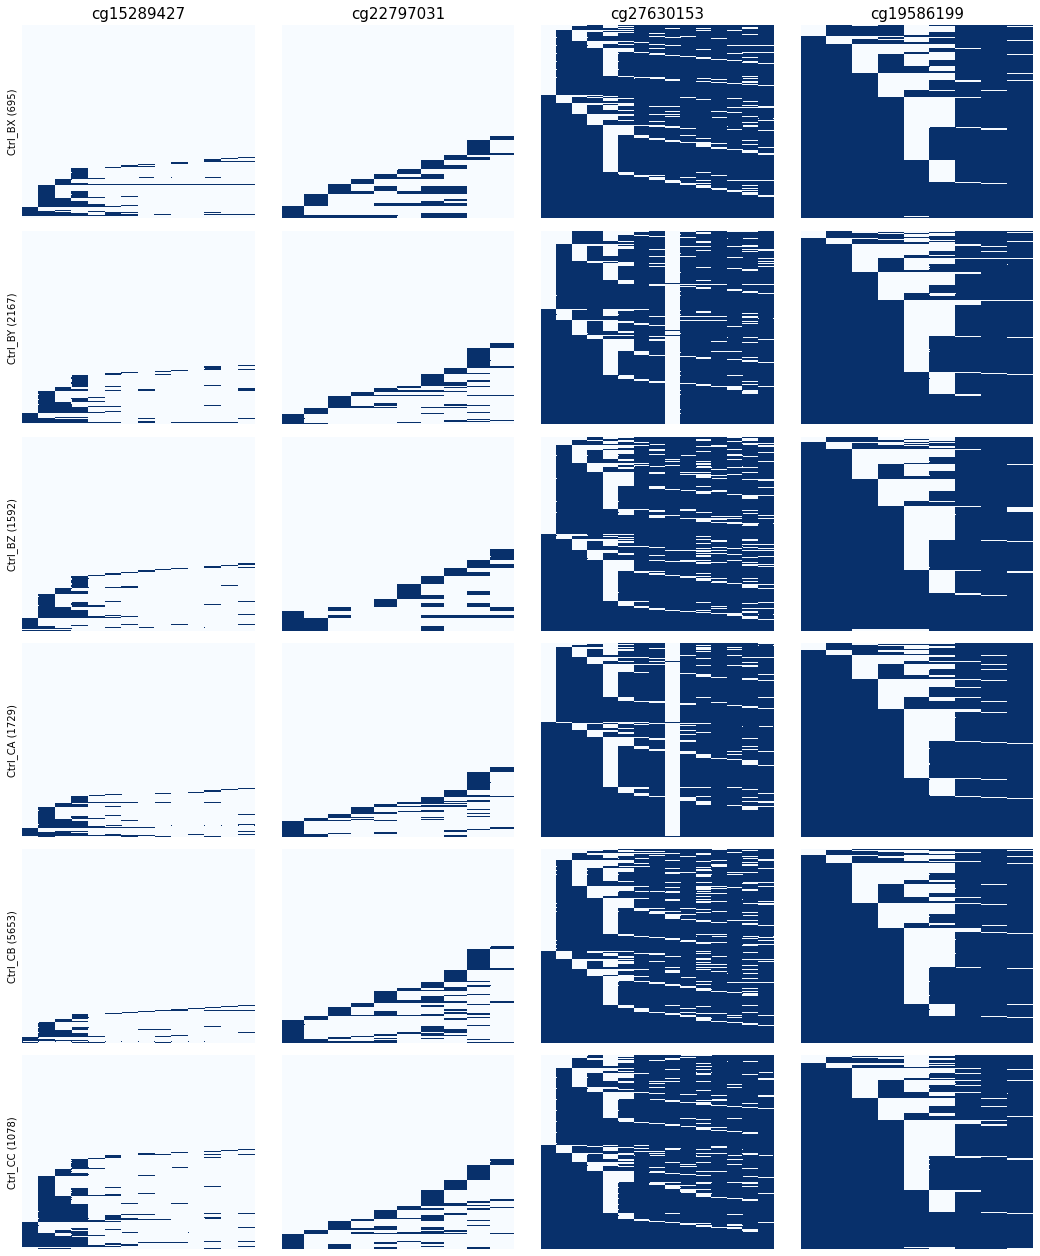

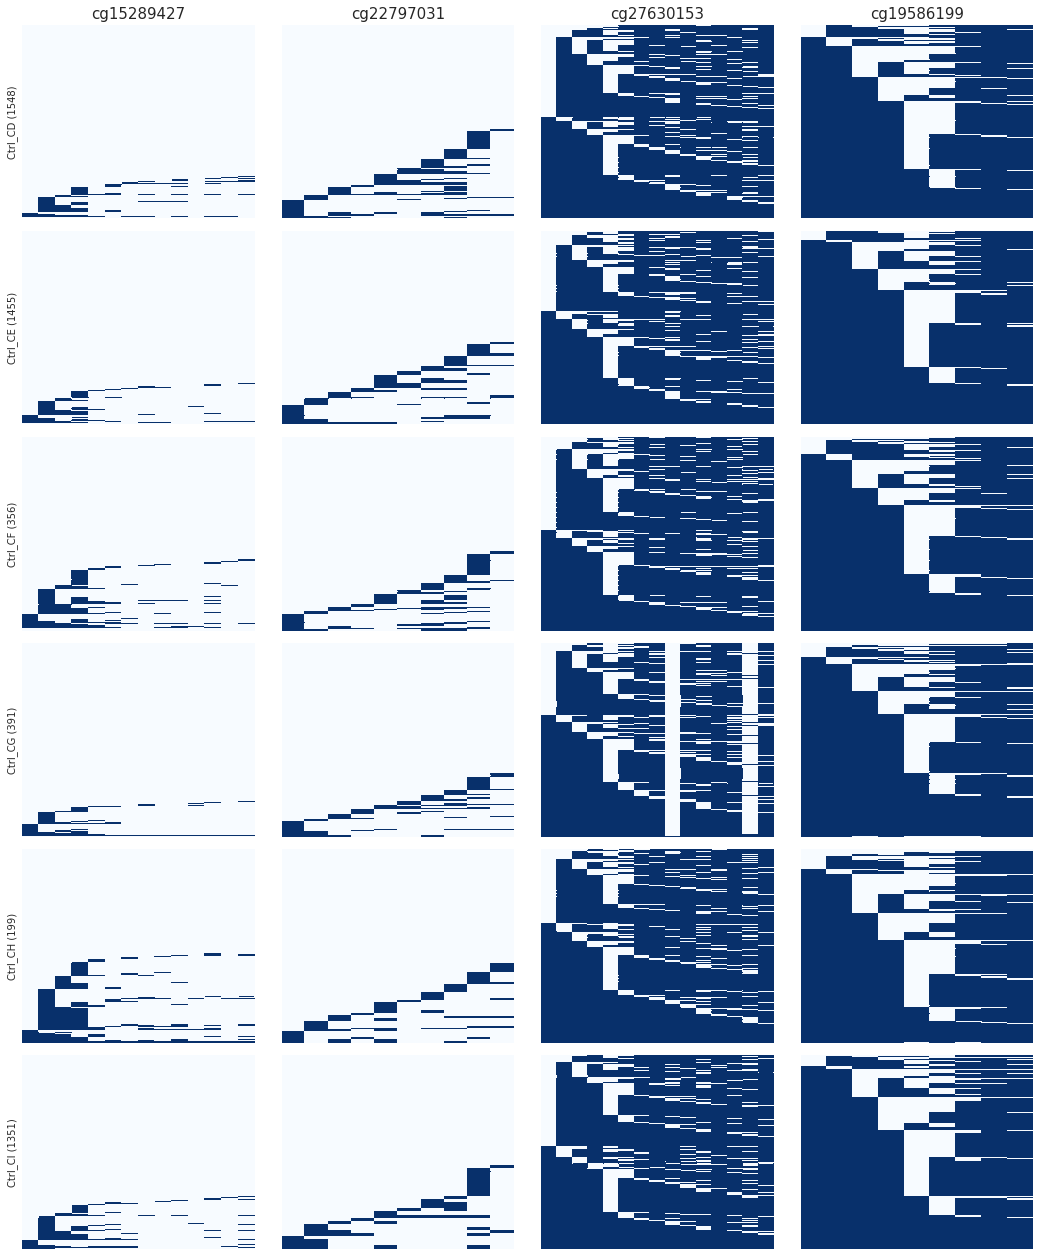

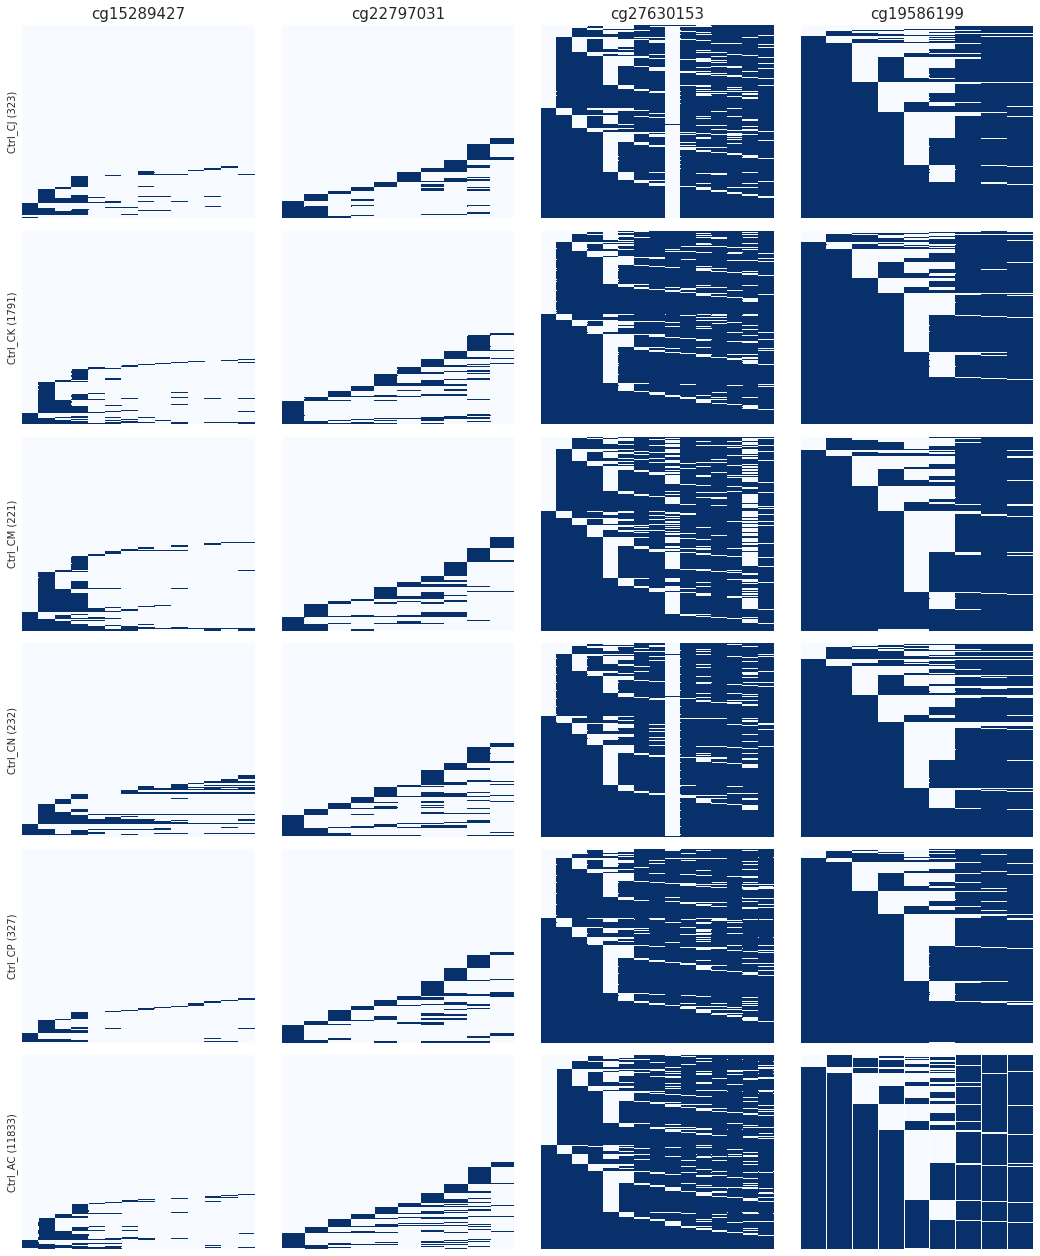

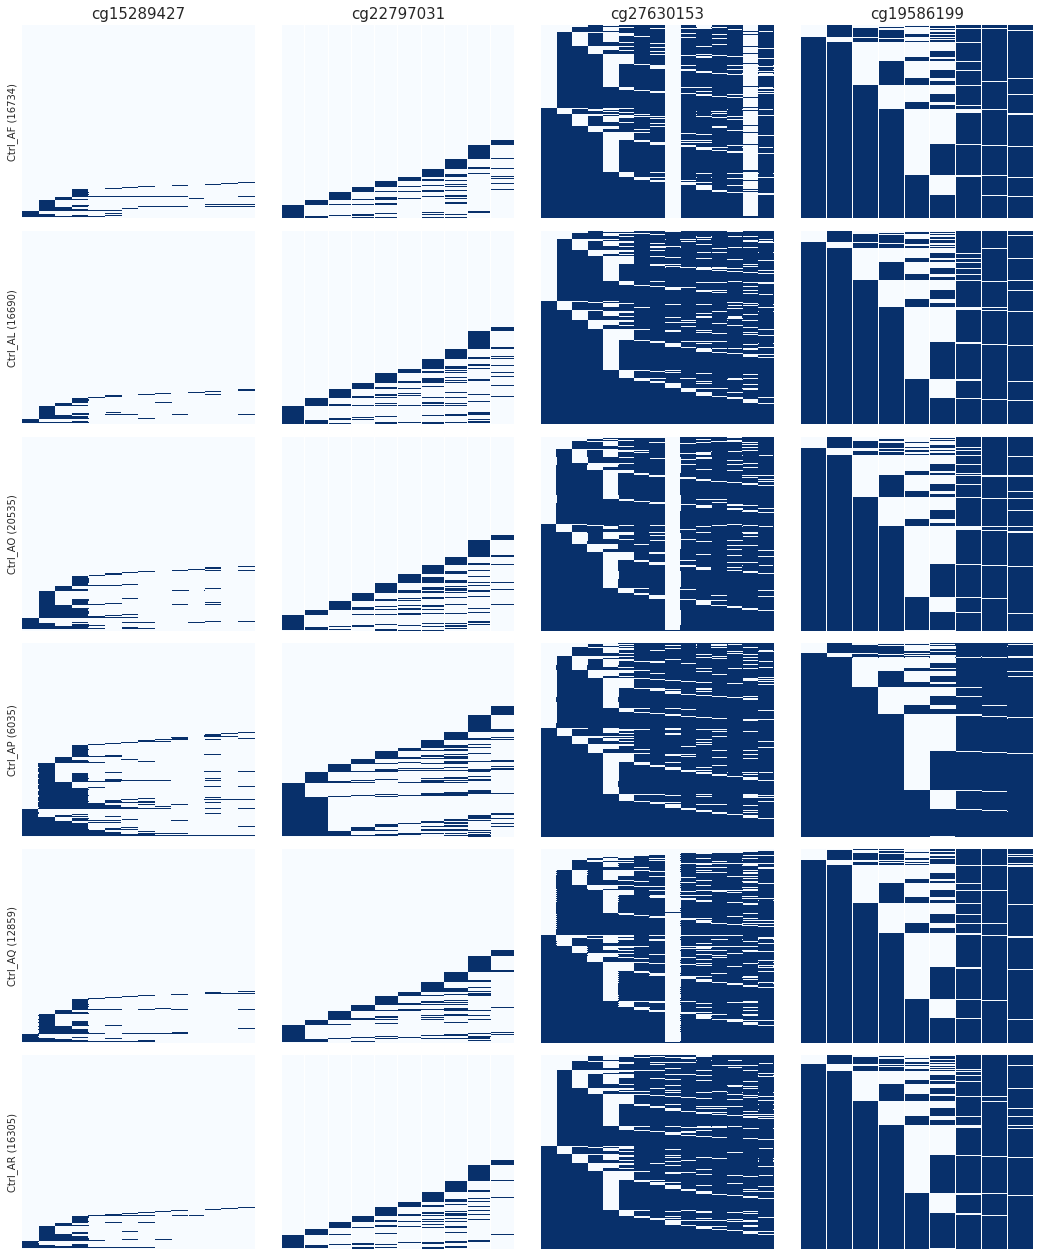

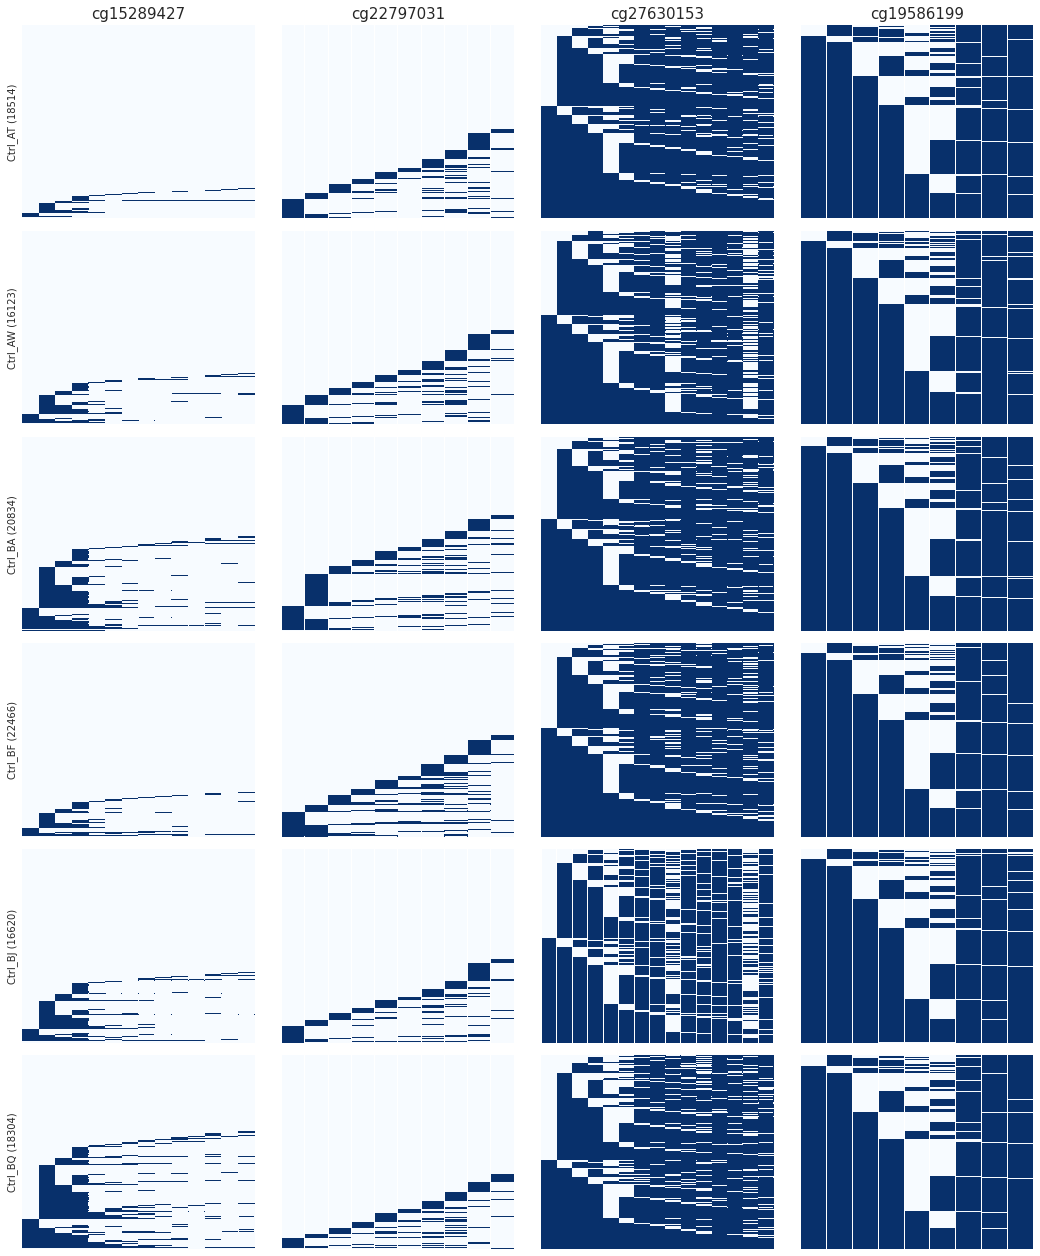

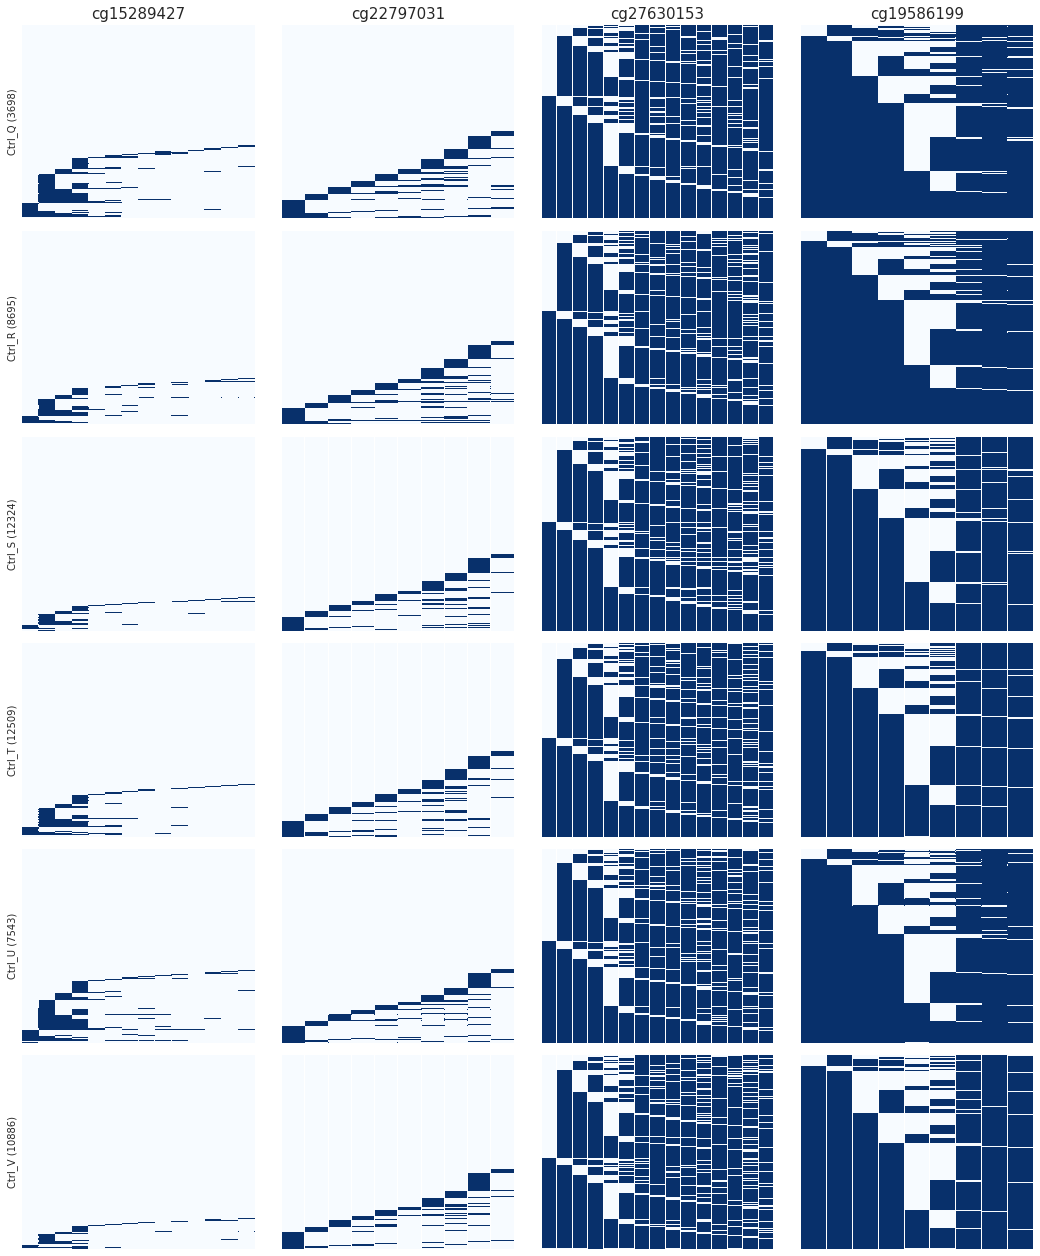

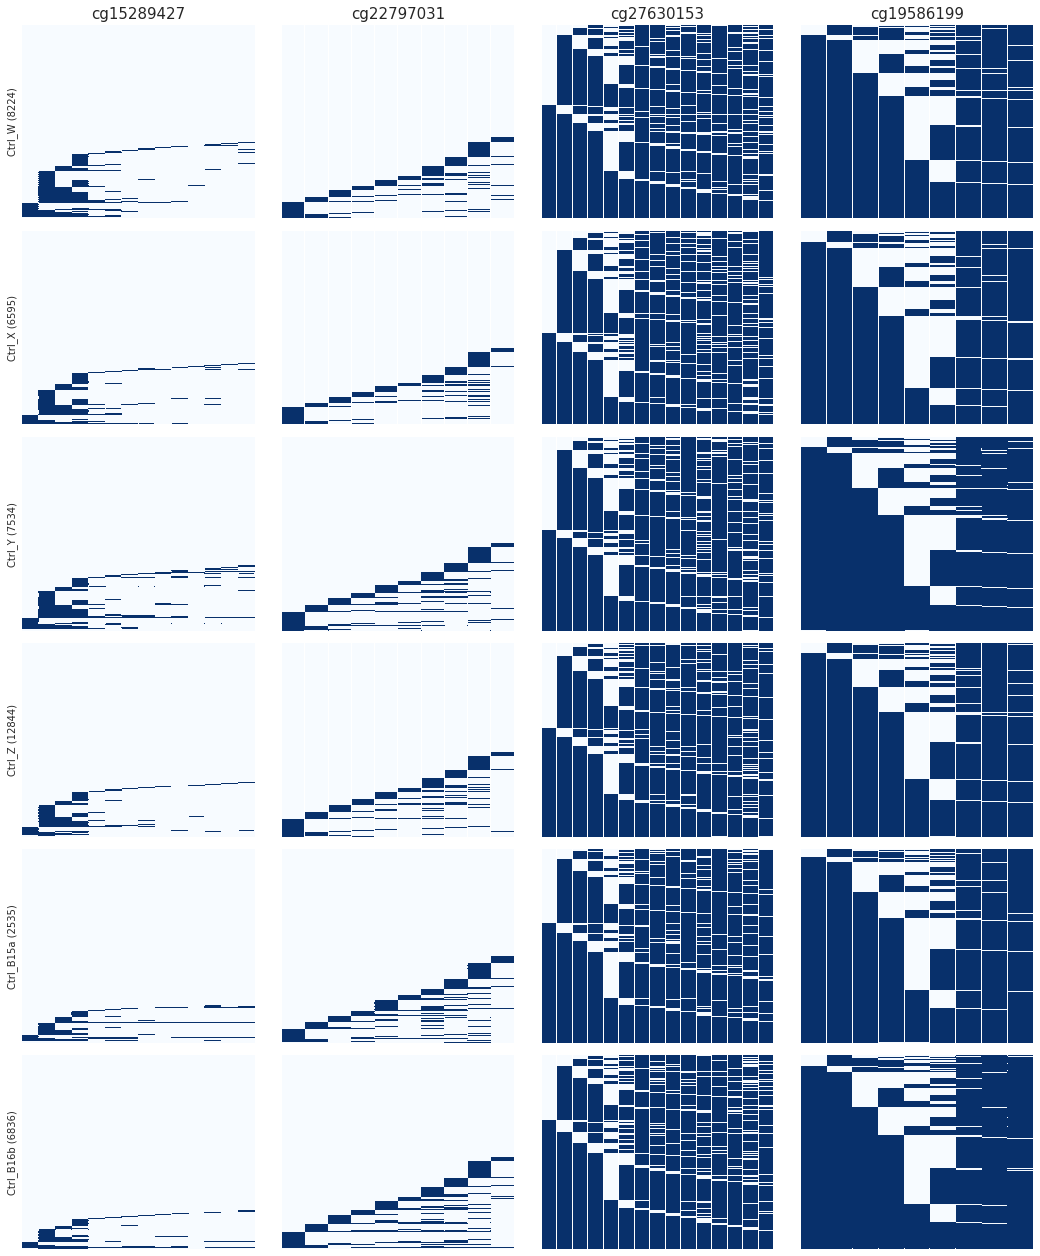

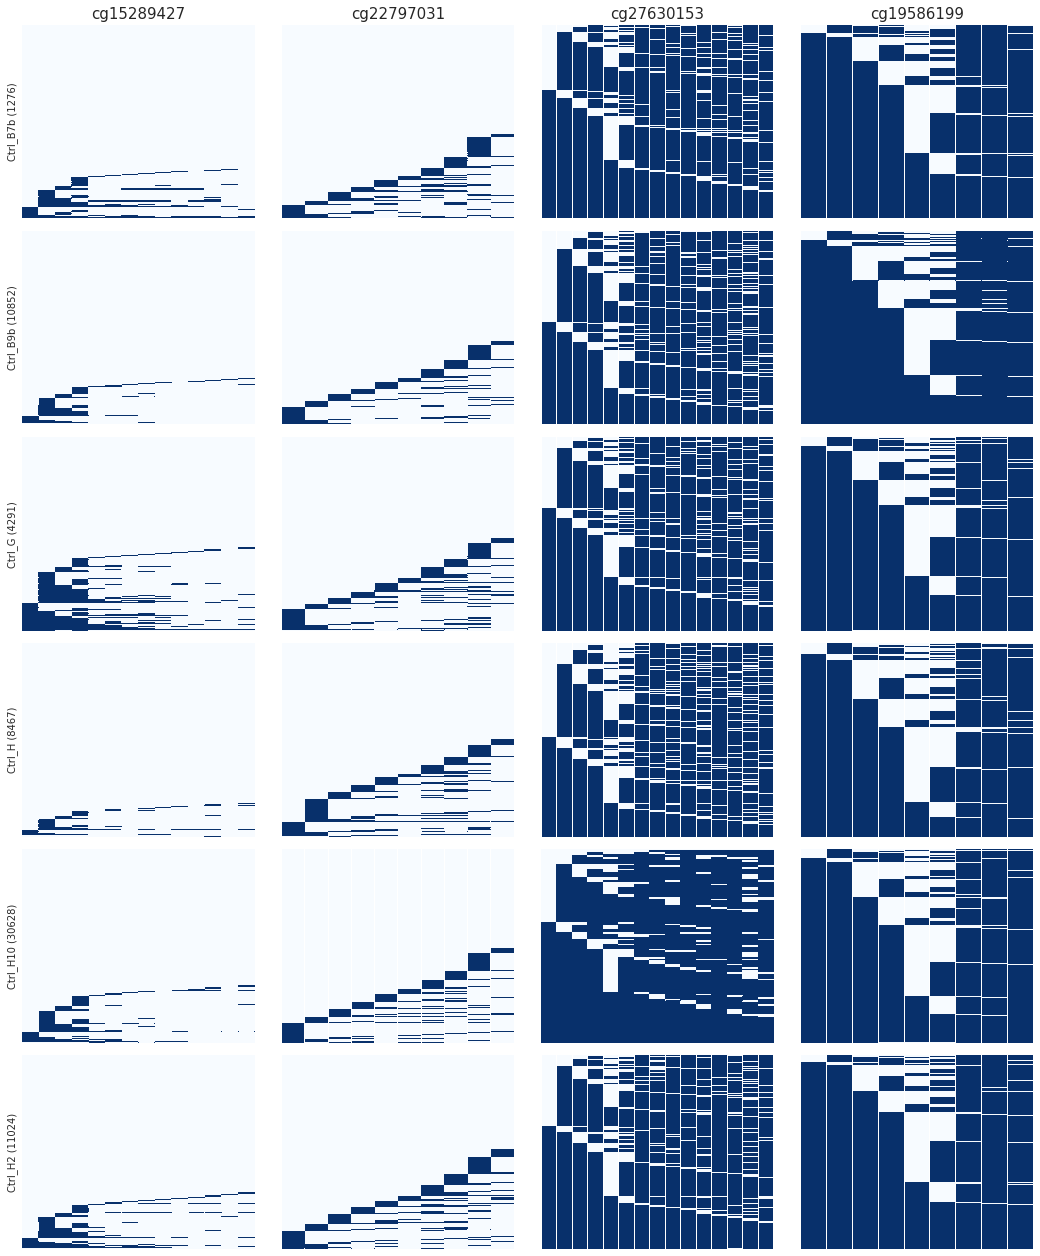

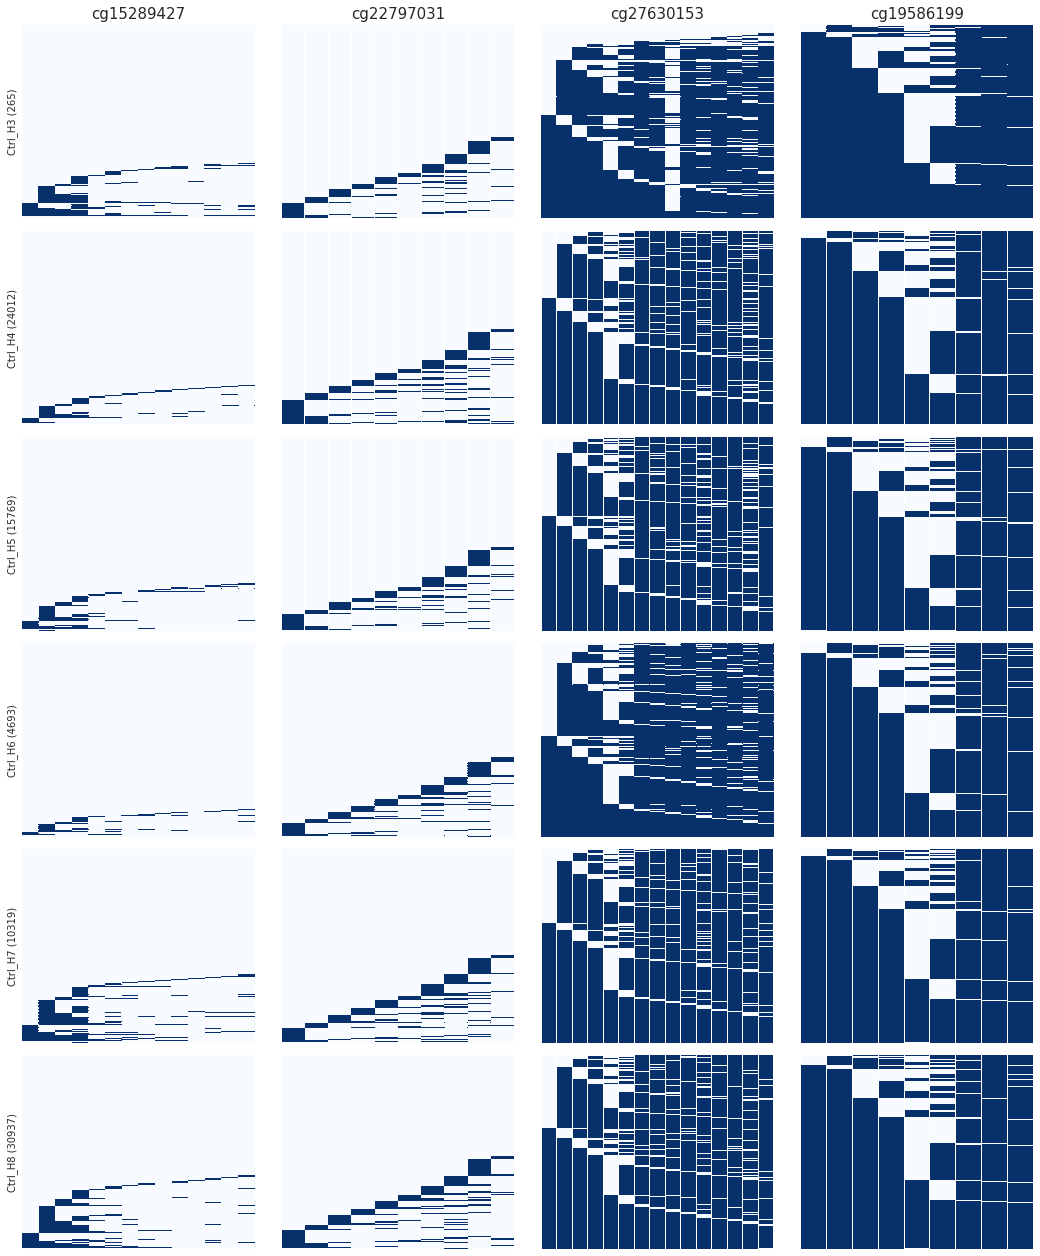

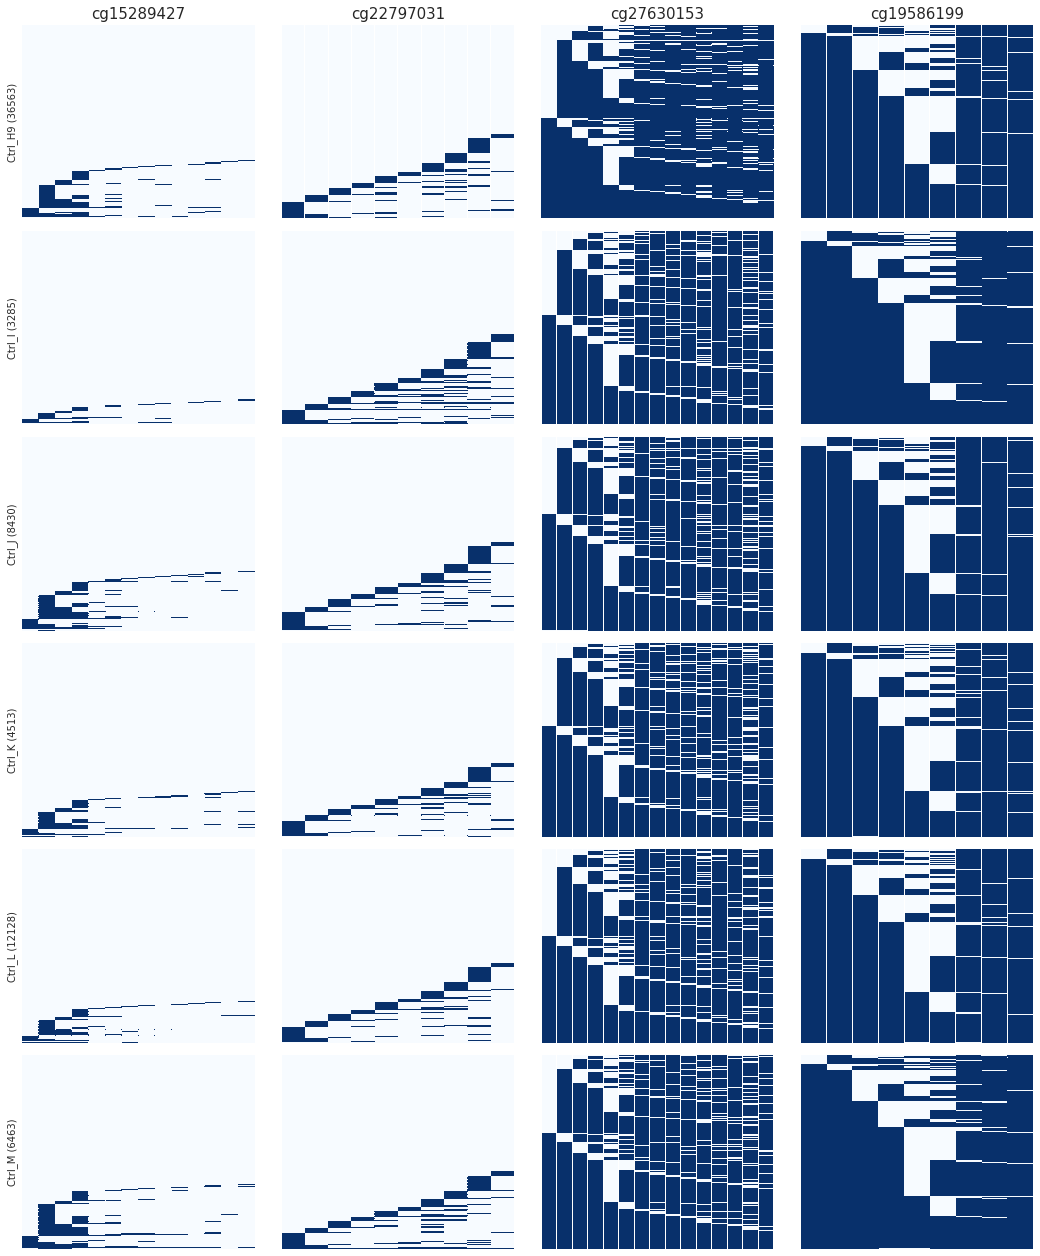

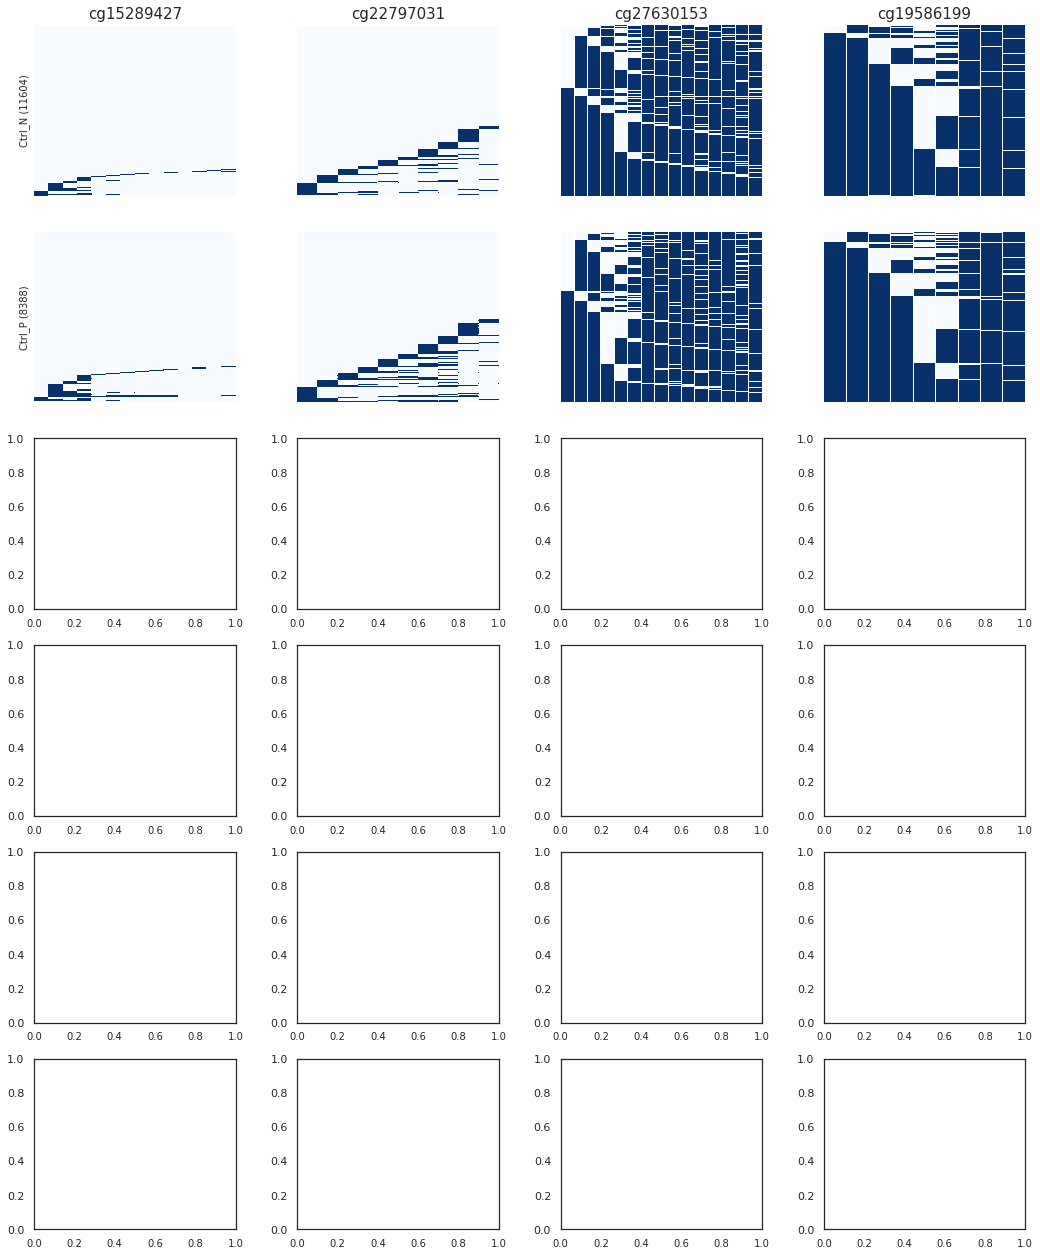

In [5]:
for gg in set(samples["Group ID"]):
    if gg in ["Ctrl"]:
        plot_pattern_heatmap(target_group = gg)
#         plot_pattern_heatmap(target_group = gg, sample_id="DD_PB_75")
#     else:
#         plot_pattern_heatmap(target_group = gg)